In [45]:
from typing import List, Tuple
import torch
import matplotlib.pyplot as plt

In [48]:
import importlib
import main
importlib.reload(main)

<module 'main' from '/Users/ytakano/projects/dass2023/adv/main.py'>

In [20]:
# 水平
dx = 10.0  # 格子間隔
nx = 40  # 格子数
nobs = 8  # 格子点数

# 時間
dt = 0.5  # 計算間隔[s]
nt = 1200  # 計算ステップ数
t_out_interval = 15  # 出力ステップ間隔
dt_out = dt * t_out_interval  # 出力間隔[s]
nt_out = nt // t_out_interval + 1  # 出力ステップ数

tt = 2  # 予報変数の時間次元 (leap-flogのため2時刻必要)

In [51]:
%%time
x_true, w_true, y, x_free, w_free, x_asim, w_asim = main.run()

CPU times: user 359 ms, sys: 3.77 ms, total: 362 ms
Wall time: 362 ms


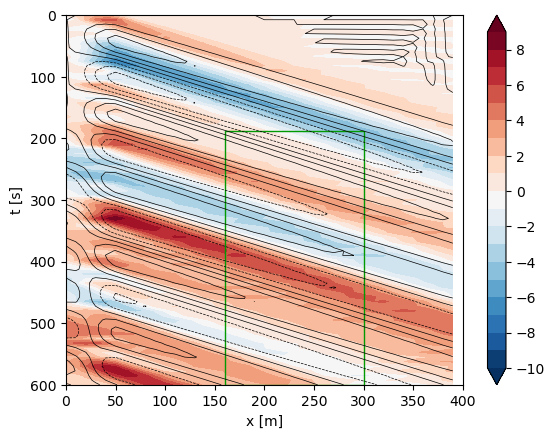

In [52]:
main.plot_xt(
    x_free - x_true, 
    torch.arange(-10, 10, 1), 
    x_free, 
    torch.arange(-20, 20, 5))

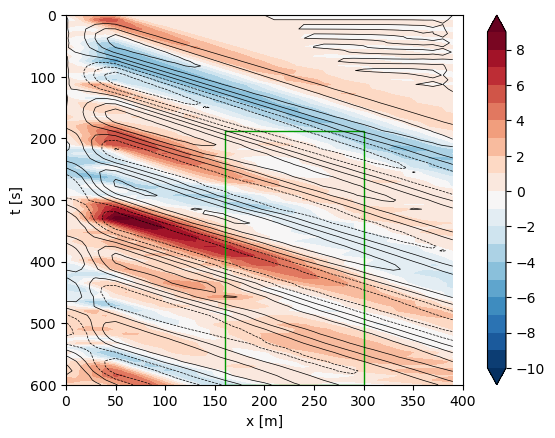

In [53]:
x_mean = x_asim.mean(dim=1)
main.plot_xt(
    x_mean - x_true, 
    torch.arange(-10, 10, 1),
    x_mean,
    torch.arange(-20, 20, 5))